In [3]:
import matplotlib.pyplot as plt
import numpy as np
from emcee import PTSampler
from scipy.integrate import trapz
%matplotlib inline

import seaborn as sns
sns.set_style(rc={'font.family': ['sans-serif'],'axis.labelsize': 25})
sns.set_context("notebook")

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.labelsize'] = 18

# Testing methods to estimate the evidence from MCMC simulations

MCMC simulations are widely used to do parameter estimation where we want to estimate
the posterior distribution of the model parameters that is $p(\theta| y)$ where $\theta$
are the model parameters and $y$ is the data. Another use for MCMC simulations is to
compute the evidence for a particular model 

$$ Z = \int_{\theta} \mathcal{L}(y|\theta) \pi(\theta) d \theta $$

If you have run an MCMC simulation then you have already calculated $\mathcal{L}(y|\theta)$
and so we would like to know how to calculate $Z$. This notebook will not attempt to
explain the various methods, but instead simply compare them.

First we need something to compare them too:

## Simplest example with only unknown frequency

We will consider a simple model of a sinuoisoid in noise e.g

$$ y(t) = \sin(2\pi f t) + n(t) $$

where $n(t) \sim N(0, \sigma)$.

Then the likelihood function is 

$$ \mathcal{L}(y | f) = 
\frac{1}{\sigma \sqrt{2\pi}} \exp\left[-\frac{(\sin(2\pi ft)-y_{i})^{2}}{2\sigma^{2}}\right]
$$

Note that we will assume that $\sigma$ is a known quantity in this. Of course
we could get more fancy and have an amplitude and phase-offset, but let's keep
it simple and focus on *how* to do the calculation. 

### Example data
First produce some example data

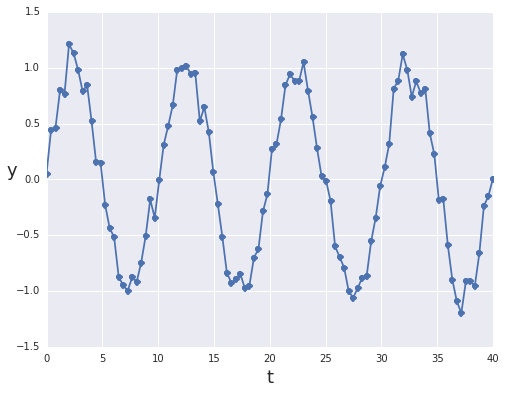

In [7]:
Freq = 0.1
sigma = 0.1

def f(t, Freq):
    return np.sin(2*np.pi*Freq*t)

N = 100
t = np.linspace(0, 40, N)
y = f(t, Freq) + np.random.normal(0, sigma, N)

plt.plot(t, y, "o-")
plt.ylabel("y", rotation='horizontal')
plt.xlabel("t")
plt.show()

## Define the prior and calculate the evidence numerically

In this case we can calculate the evidence by evaluating the one-dimensional integral

$$ Z = \int_{f} \mathcal{L}(y|\theta) \pi(f) d f $$

We set a uniform prior on $f$:
 
$$ \pi(f) = \left\{\begin{array}{cc} 1 & \textrm{if } 0 < f < 1 \\ 0 & \textrm{otherwise}\end{array}\right]$$

Then our integral become

$$ Z = \int_{0}^{1} \mathcal{L}(y|\theta)  d f $$


#### The integrand
Firstly we calculate the integrand and plot it. Notably it is zero 
in many places so we need only integrate it where it is non-zero:

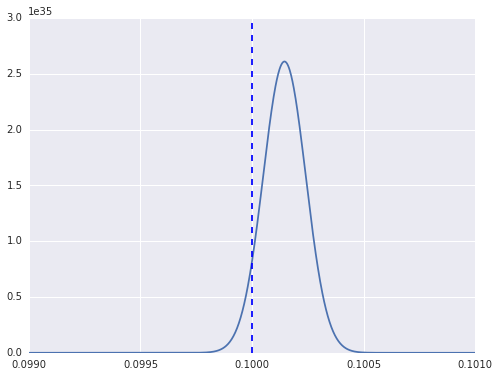

In [9]:
def l(t, y, f):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*(np.sin(2*np.pi*f*t) - y)**2 / sigma**2)

frequencies = np.linspace(0.099, 0.101, 1000)
integrand = [np.prod(l(t, y, fi)) for fi in frequencies]

plt.plot(frequencies, integrand)
plt.axvline(0.1, ls="--")
plt.show()

This is actually the posterior density of $f$, so it should agree with the
MCMC simulations later one!

Now we integrate numerically

In [10]:
lnZ_act = np.log(trapz(integrand, frequencies))
print "ln(Z) = {}".format(lnZ_act)

ln(Z) = 73.2119972635


## Result from MCMC: Parallel-tempered method and harmonic mean

Firstly let us run an MCMC simulation to do the 'parameter estimation'. Note 
we will use the same prior. It is important here to choose a proper prior for
two reasons: when you do a model comparison, you want to have meaningful results
and an improper prior can produce errors in the estimation of the evidence!

We will be checking to types of evidence estimates: thermodynamic integratino method
[which is described here](http://dan.iel.fm/emcee/current/api/?highlight=pt#emcee.PTSampler).
And the Hamonic mean approximation, which is [slated here](https://radfordneal.wordpress.com/2008/08/17/the-harmonic-mean-of-the-likelihood-worst-monte-carlo-method-ever/). 


In [11]:
ntemps = 10
nwalkers = 100
ndim = 1
nsteps = 1000
p = np.array([0.1])
scatter_val = 0.001



def logp(params):
    if all(params > 0) and all(params < 1):
        return 0.0
    else:
        return -np.inf


def logl(params, t, y):
    sigma2 = sigma**2
    res = np.array(y - f(t, *params))
    N = len(res)
    summation = np.sum(res**2 / sigma2) + N*np.log(2*np.pi*sigma2)
    return -0.5*summation

betas = np.logspace(0, -5, ntemps, base=10)

sampler = PTSampler(ntemps, nwalkers, ndim, logl, logp, loglargs=[t, y], betas=betas)
ntemps = sampler.ntemps
p0 = [[p + scatter_val * np.random.randn(ndim)
      for i in xrange(nwalkers)] for j in xrange(ntemps)]
(pos, lnprob, rstate) = sampler.run_mcmc(p0, nsteps)

Note that here I am using a parallel-tempererd sampler because we will be using the tempered samples
to estimate the evidence. Contrary to normal use we have defined the `betas` manually, we will get
to the reasons for this later. Firstly let's check that we have a reasonable estimate of the prior

We plot the chain itself (there is only one since we have only one free parameter).
Note that the burn-in period is non-existent in this example.

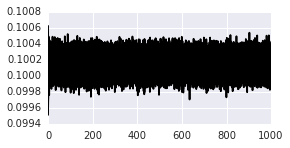

In [12]:
chain = sampler.chain[:, :, :, :]
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(4, 2*ndim))
axes.plot(chain[0, :, :, 0].T, color='k')
plt.show()

Next we plot the maximum likelihood result against the data to see
if it fits and make sense.

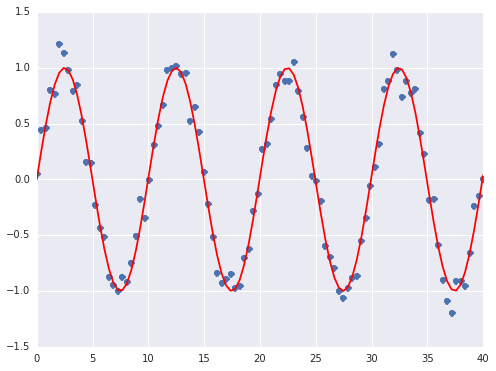

In [13]:
flat_zero_temp_chain = chain[0, :, :, :].flatten()
lnprobs = sampler.lnprobability[0, :, :]
max_idx = np.argmax(lnprobs)
max_params = flat_zero_temp_chain[max_idx]

fig, ax = plt.subplots()
ax.plot(t, y, "o")
ax.plot(t, f(t, max_params), "-r")
plt.show()

Finally lets plot the posterior density distribution of $f$

0.0995115935121


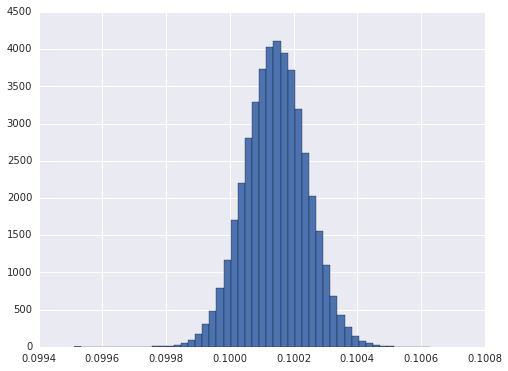

In [14]:
out = plt.hist(flat_zero_temp_chain, bins=50, normed=True)
print min(flat_zero_temp_chain)

### Evidence calculation: Thermodynamic integration

The first, and better method to discuss, is the TD integration. If you used the `PTSampler` then
calculating the evidence, and an estimate of the error, is as simple as

In [16]:
(lnZ_pt, dlnZ_pt) = sampler.thermodynamic_integration_log_evidence()
print "lnZ_pt = {} +/- {}".format(lnZ_pt, dlnZ_pt)
print "Error to numeric = {}".format(abs(lnZ_pt - lnZ_act)) 

lnZ_pt = 71.7847521625 +/- 11.3585954318
Error to numeric = 1.42724510099


This looks good, our error to the actual value is much less than the estimates error. But we should always
check that the result is sensible. We will do this by doing the calculation explicitly, then discuss which aspects give good diagnostics for the confidence we should have in the estimate.

### Explicitly doing the calculation

Just to check our understanding of what the `PTSampler` is doing under the hood
lets do the thing by hand. I've stuck as closely as possible to what is done in
in the code itself, but made everything very explicit. In addition the code estimates
the error, I've ignored that part for simplicity.

Essentially we want to evaluate

$$ \log(Z) \approx \int_{0}^{1} \langle \mathcal{L} \rangle d\beta $$

where the average is over all chains and walkers except the burnin period.

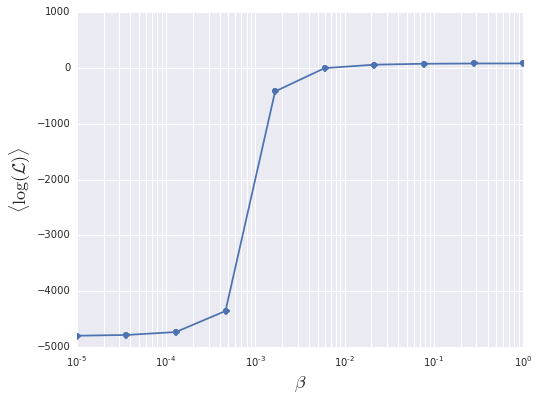

In [36]:
fburnin = 0.1
betas = sampler.betas
logls = sampler.lnlikelihood

nsteps = logls.shape[2]
istart = int(fburnin * nsteps *fburnin + 0.5)
             
logls = logls[:, :, istart:]  # Drop the burn-in steps 
logls_ave = np.mean(logls, axis=1)  # Average over the steps 
logls_ave = np.mean(logls_ave, axis=1) # Average over the walkers

plt.semilogx(betas, logls_ave, "-o")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\langle \log(\mathcal{L}) \rangle$")
plt.show()

Here we are showing the plot of the log-likelihood against the the inverse temperatures. This plot should always be checked when using this method: if two few points are cover the intemediatary regime then the method will produce a result, but it may not be meaningful. 

To estimate the evidence we numerically integrate $\beta$ between $[0, 1]$. I am still in two minds as to how to do this so I will describe both:

##### Right Riemann sum

This is the method currently in the master branch of `emcee` (not the branch I used to create this post, which uses the Trapedzoid rule, which in this instance is more accurate). The motivation for using
such a sum is to account for the fact that in general we do not include a $\beta = 0$ 
temperature but stop at some $T_{\textrm{max}}$. 

$$ S = \sum_{i=1}^{N} y_{i} (x_{i} - x_{i-1}) $$

the implementation and result is:

In [40]:
mean_logls = np.mean(np.mean(logls, axis=1)[:, istart:], axis=1)
lnZ_RRS = -np.dot(mean_logls, np.diff(np.concatenate((betas, np.array([0])))))
print "RRS lnZ = {} \nError to actual = {}".format(lnZ_RRS, abs(lnZ_act - lnZ_RRS))

RRS lnZ = 77.0181406674 
Error to actual = 3.80614340393


Note that we take a negative here because of the reversed ordering of $\beta$ in the sampler.

This overestimates the value as is common to the right Riemann sum for monotonically
increasing functions. 

##### Trapedzoidal rule 

An alternative which avoids this over-estimation is the simple trapedzoidal rule. But doing
this does not fix the issue of not having a $\beta=0$ temperature, we must rely on the highest
temperature being sufficiently high to make this error small. 

In [42]:
lnZ_trap = -trapz(logls_ave, betas)
print "Trap lnZ = {} \nError to actual = {}".format(lnZ_trap, abs(lnZ_act - lnZ_trap))

Trap lnZ = 71.879981906 
Error to actual = 1.33201535747


### Harmonic mean

Finally just for fun let's also compute the Harmonic mean approximation to see 
how it compares

In [48]:
def HarmonicMeanApprox(lnprob):
    inv_prob = np.exp(-lnprob)
    return 1.0/np.average(inv_prob)

lnprobs = sampler.lnprobability[0, :, N/2:] # Zeroth temperature lnprobs
lnZ_HMA = np.log(HarmonicMeanApprox(lnprobs))
print "HMA lnZ = {} \nError to actual = {}".format(lnZ_HMA, abs(lnZ_HMA - lnZ_act))

HMA lnZ = 80.1726394628 
Error to actual = 6.96064219932


So this is quite a bit off!